In [203]:
import librosa
import numpy as np
import pandas as pd
from datetime import timedelta
import glob
import natsort
import pandas as pd
import numpy as np
import math
import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

# from tensorflow.keras import optimizers
# from keras.callbacks import ReduceLROnPlateau
# from keras.models import Sequential
# from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
# from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Conv2D, MaxPooling2D,BatchNormalization, MaxPooling1D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, ZeroPadding2D
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from datetime import timedelta

from keras.callbacks import ModelCheckpoint
# from tensorflow.keras import optimizers
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 


In [4]:
def visualize(path: str):
    
    # reading the audio file
    raw = wave.open(path)
    Audio(path)  
    # reads all the frames 
    # -1 indicates all or max frames
    signal = raw.readframes(-1)
    signal = np.frombuffer(signal, dtype ="int16")
      
    # gets the frame rate
    f_rate = raw.getframerate()
  
    # to Plot the x-axis in seconds 
    # you need get the frame rate 
    # and divide by size of your signal
    # to create a Time Vector 
    # spaced linearly with the size 
    # of the audio file
    time = np.linspace(
        0, # start
        len(signal) / f_rate,
        num = len(signal)
      
    )
    Audio(path)
   
  
    # using matlplotlib to plot
    # creates a new figure
    plt.figure(1)
      
    # title of the plot
    plt.title(path.split('_')[2])
      
    # label of x-axis
    plt.xlabel("Time")
     
    # actual ploting
    plt.plot(time, signal)
      
    # shows the plot 
    # in new window
    plt.show()
  
    # you can also save
    # the plot using
    # plt.savefig('filename')
  

In [4]:
def createFileList(format='.wav'):
    fileList = []
    #print(/content/Crema)
    for root, dirs, files in os.walk('/Users/omarkhaled/Documents/pr/Crema', topdown=False):
        for name in files:
            if name.endswith(format):
                fullName = os.path.join(root, name)
                fileList.append(fullName)
    return fileList



In [5]:
fileList = createFileList()
Emotions=['HAP','DIS','FEA','NEU','SAD','ANG']
Emotions=np.array(Emotions)
#print(fileList[0].split('_')[0]+'_'+fileList[0].split('_')[1]+'_'+Emotions[0]+'_'+'XX.wav')
for feel in Emotions:
  path=fileList[1500].split('_')[0]+'_'+fileList[0].split('_')[1]+'_'+feel+'_'+'XX.wav'
  #path='1001'+'_'+'DFA'+'_'+feel+'_'+'XX.wav'

  # visualize(path)
 
 
 

In [ ]:
audio = tfio.audio.AudioIOTensor(fileList[0])
audio=audio.to_tensor()
tensor = tf.cast(audio, tf.float32) / 32768.0
print(audio.shape)



(47514, 1)


In [6]:
onehot_encoded_data=[]
for i in fileList:
  onehot_encoded_data.append([i.split('_')[2]])
emotion_df = pd.DataFrame( onehot_encoded_data , columns=['Emotions'] )

# dataframe for path of files.
path_df = pd.DataFrame(fileList, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)


onehot_encoded_data=np.array(onehot_encoded_data)
encoder = OneHotEncoder(sparse=False)
onehot_encoded_data = encoder.fit_transform(onehot_encoded_data)


Crema_df.head()

,Emotions,Path
0,ANG,/Users/omarkhaled/Documents/pr/Crema/1022_ITS_...
1,ANG,/Users/omarkhaled/Documents/pr/Crema/1037_ITS_...
2,NEU,/Users/omarkhaled/Documents/pr/Crema/1060_ITS_...
3,NEU,/Users/omarkhaled/Documents/pr/Crema/1075_ITS_...
4,DIS,/Users/omarkhaled/Documents/pr/Crema/1073_IOM_...


In [7]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)


    

In [8]:
def shortTermEnergy(frame):
  return sum( [ abs(x)**2 for x in frame ] ) / len(frame)

In [9]:
def zeroCrossingRate(frame):
  signs             = numpy.sign(frame)
  signs[signs == 0] = -1

  return len(numpy.where(numpy.diff(signs))[0])/len(frame)

In [15]:
def ExtractFeatures(soundData,samplingFrequency, frameLength, hopLength):
 zcr = librosa.feature.zero_crossing_rate(y=soundData, frame_length=frameLength,hop_length=hopLength, center=False)
 energy = librosa.feature.rms(y=soundData, center=False, frame_length = frameLength, hop_length=hopLength)
 zcr_col_name = ['Zero_Crossing_Rate']
 energy_col_name = ['Energy']
 column_names = [energy_col_name +zcr_col_name]
 numpy_array_of_features = np.vstack((energy, zcr))
 oneSecondFeatures= pd.DataFrame(numpy_array_of_features.T, columns=column_names)
 return oneSecondFeatures

In [16]:
featuresFile=pd.DataFrame()
for i in range(len(fileList)):
    soundData, samplingFrequency = librosa.load(fileList[i], sr=None)
    oneFileFeatures = ExtractFeatures(soundData,samplingFrequency,frameLength=samplingFrequency, hopLength=samplingFrequency+1)
    featuresFile=featuresFile.append(oneFileFeatures)
    

In [33]:
def extract_features(data,sample_rate):
    #data, sample_rate = librosa.load(fileList)
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally
    
    #short term energy
    result= shortTermEnergy((result,shortTermEnergy(data)))
    
    #spectral centroid
    cent = np.mean(librosa.feature.spectral_centroid(y=data, sr=sample_rate).T,axis = 0)
    result = np.hstack((result, cent))
    
    #spectral bandwidth
    spec_bw = np.mean(librosa.feature.spectral_bandwidth(y=data, sr=sample_rate).T,axis = 0)
    result = np.hstack((result, spec_bw))


    #spectral flattness
    flatness = np.mean(librosa.feature.spectral_flatness(y=data).T,axis=0)
    result = np.hstack((result, flatness))

    return result


In [34]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)



In [91]:
def get_features(path, augment):
    # duration and offset are used to take care of the no audivvo in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path)#, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data,sample_rate)
 
    result = np.array(res1)
    
    if augment:
        # data with noise
        noise_data = noise(data)
        
        res2 = extract_features(noise_data,sample_rate)
        
        result = np.vstack((result, res2)) # stacking vertically
        
        # data with stretching and pitching
        new_data = stretch(data)
        
        data_stretch_pitch = pitch(new_data, sample_rate)
        
        res3 = extract_features(data_stretch_pitch,sample_rate)
        
        result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [41]:
##function generate mel spectogram for read audio 
def get_mel_wav(data,sr):
  mel_spectrogram = librosa.feature.melspectrogram(data, sr=sr, n_fft=2048, hop_length=512, n_mels=128)
  log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)
  return log_mel_spectrogram

In [132]:
##splitting thDS to test,train,val and specifing batch_size,epochs,num_classes
X1_train, X1_test, y1_train, y1_test = train_test_split( fileList, onehot_encoded_data, test_size=0.3, random_state=42,shuffle='Yes')
X1_trainfinal, X1_vaildate, y1_trainfinal, y1_validate = train_test_split( X1_train, y1_train, test_size=0.05, random_state=42,shuffle='Yes')

batch_size = 128
epochs = 50
num_classes = 6


In [133]:
X_train = X1_trainfinal
y_train = y1_trainfinal

In [134]:
X, Y = [], []
X_train=np.array(X_train)
i =0
runs =100
for path, emotion in zip(X_train,y_train):
    if i%runs == 0:
        print(i)
    feature = get_features(path,True)
    X.append(feature)
    Y.append(emotion)
    i+=1

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900


In [135]:
X_train_features = np.array(X)
y_train_features = np.array(Y)
print(X_train_features.shape,y_train_features.shape)

(4948, 3, 37) (4948, 6)


In [146]:
# test = np.copy(X_train_features)
# # print(test[0])
# test = test.reshape(((test.shape[0]*test.shape[1]),test.shape[2]))
# # print(test[0],test[1],test[2])
# X_train_features = test
print(X_train_features.shape)

(14844, 37)


In [147]:
X_test = X1_test
y_test = y1_test
X_validate = X1_vaildate
y_validate = y1_validate

In [148]:
X2, Y2 = [], []
X_test=np.array(X_test)
for path, emotion in zip(X_test,y_test):
    feature = get_features(path,False)
    X2.append(feature)
    Y2.append(emotion)

In [ ]:
X3, Y3 = [], []
X_validate=np.array(X_validate)

for path, emotion in zip(X_validate,y_validate):
    feature = get_features(path,False)
    X3.append(feature)
    Y3.append(emotion)
        
   

(4948,)
14844


In [150]:
X_test_features = np.array(X2)
y_test_features = np.array(Y2)
X_validate_features = np.array(X3)
y_validate_features = np.array(Y3)

In [93]:
print(X3[0])

[1.17254167e-03 1.51058436e-01 1.18653242e-01 1.07475736e-01
 1.45796036e-01 1.15853950e-01 9.25893570e-02 1.22243218e-01
 2.27065605e-01 3.19378769e-01 3.04035667e-01 1.70959080e-01
 1.00753580e-01 1.01748595e+05 7.88966639e+03 3.06467698e+02
 1.78724808e+03 2.02318282e+01 4.36894585e+02 6.93954878e+01
 5.68808766e+01 3.54221804e+01 1.09668103e+01 6.11572339e-01
 7.71051115e+00 5.56383231e+00 6.19429731e+01 6.84154966e+00
 8.19234327e+01 2.91259596e-01 3.85355737e+01 2.52124562e+00
 1.54893605e+01 5.85578764e-05 1.28033789e+03 1.82630135e+03
 1.56895199e-04]


In [50]:
Labels=[]
for i in fileList:
  Labels.append([i.split('_')[2]])

Labels=np.array(Labels)
encoder = OneHotEncoder(sparse=False)
onehot_encoded_data = encoder.fit_transform(Y.reshape(1, -1))
Labels=onehot_encoded_data
Labels.shape

AttributeError: 'list' object has no attribute 'reshape'

In [19]:
print(fileList.shape)

AttributeError: 'list' object has no attribute 'shape'

In [ ]:
len(X), len(Y),len(fileList)

(22326, 22326, 7442)

In [ ]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()
print(Features)


              0         1  ...        33                          labels
0      0.002354  0.175458  ...  0.000218  [0.0, 1.0, 0.0, 0.0, 0.0, 0.0]
1      0.018581  0.247202  ...  0.000229  [0.0, 1.0, 0.0, 0.0, 0.0, 0.0]
2      0.004000  0.143874  ...  0.000040  [0.0, 1.0, 0.0, 0.0, 0.0, 0.0]
3      0.000626  0.189521  ...  0.000038  [0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
4      0.000880  0.208118  ...  0.000039  [0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
...         ...       ...  ...       ...                             ...
22321  0.019989  0.212895  ...  0.000234  [0.0, 1.0, 0.0, 0.0, 0.0, 0.0]
22322  0.001286  0.090242  ...  0.000047  [0.0, 1.0, 0.0, 0.0, 0.0, 0.0]
22323  0.000765  0.239458  ...  0.000063  [0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
22324  0.000758  0.239885  ...  0.000063  [0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
22325  0.000986  0.192019  ...  0.000012  [0.0, 0.0, 0.0, 0.0, 0.0, 1.0]

[22326 rows x 35 columns]


In [ ]:
len(X), len(Y)

(22326, 22326)

In [ ]:
Y=np.array(Y).reshape(-1,1)

In [ ]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [ ]:
Y.shape

(22326,)

In [ ]:
#Y=np.array(Y.reshape(-1,6))
print(Y.shape)
encoder = OneHotEncoder(sparse=False)
Y = encoder.fit_transform(Y)

In [ ]:
x_trainandvaildate, x_test, y_trainandvaildate, y_test = train_test_split(X, Y,test_size=0.3, random_state=0, shuffle=True)
x_train, x_validate, y_train, y_validate = train_test_split(x_trainandvaildate, y_trainandvaildate, test_size=0.05, random_state=0, shuffle=True)
x_trainandvaildate.shape, y_trainandvaildate.shape , x_test.shape , y_test.shape, x_validate, y_validate

((15628, 34),
 (15628,),
 (6698, 34),
 (6698,),
 array([[2.94818900e-03, 2.47433376e-01, 2.20599105e-01, ...,
         1.93498489e+01, 9.22558607e+00, 8.35139271e-05],
        [4.52746566e-03, 2.15280033e-01, 1.42886651e-01, ...,
         5.30268015e+01, 4.17525173e+00, 5.98518267e-03],
        [7.96524157e-03, 2.22480556e-01, 2.06250204e-01, ...,
         6.10222060e+00, 9.37526359e+00, 1.28653177e-03],
        ...,
        [1.75617915e-03, 1.46672345e-01, 1.98409407e-01, ...,
         1.29418599e+01, 1.66863242e+00, 1.49847979e-05],
        [1.80944509e-03, 2.28233134e-01, 2.42053720e-01, ...,
         1.54291177e+00, 1.98442353e+01, 1.07395741e-04],
        [2.02540241e-02, 2.20169645e-01, 3.00212640e-01, ...,
         3.63884257e+01, 1.94426793e+01, 1.05702574e-04]]),
 array([array([0., 0., 0., 0., 1., 0.]), array([0., 0., 1., 0., 0., 0.]),
        array([1., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 1.]),
        array([0., 1., 0., 0., 0., 0.]), array([0., 0., 0., 1., 0., 0

In [ ]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_validate=scaler.transform(x_validate)
x_train.shape, y_train.shape, x_test.shape, y_test.shape


((14846, 34), (14846,), (6698, 34), (6698,))

In [ ]:
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_validate = np.expand_dims(x_validate, axis=2)
#y_train=np.expand_dims(y_train, axis=1)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((14846, 34, 1), (14846,), (6698, 34, 1), (6698,))

In [ ]:
y_train1=[]
for i in range(0,len(y_train)):
  y_train1.append(y_train[i])
y_train1=np.array(y_train1)  
print(y_train1.shape)  

y_validate1=[]
for i in range(0,len(y_validate)):
  y_validate1.append(y_validate[i])
y_validate1=np.array(y_validate1)  
print(y_validate1.shape)  



y_test1=[]
for i in range(0,len(y_test)):
  y_test1.append(y_test[i])
y_test1=np.array(y_test1)  
print(y_test1.shape)  






(14846, 6)
(782, 6)
(6698, 6)


In [136]:
print(X_train_features.shape,y_train_features.shape,X_test_features.shape,y_test_features.shape,X_validate_features.shape,y_validate_features.shape)

(4948, 3, 37) (4948, 6) (2233, 37, 1) (2233, 6, 1) (261, 37, 1) (261, 6, 1)


In [151]:
X_train_features = X_train_features[:,:,np.newaxis]
# y_train_features = y_train_features[:,:,np.newaxis]
X_test_features  = X_test_features[:,:,np.newaxis]
# y_test_features = y_test_features[:,:,np.newaxis]
X_validate_features = X_validate_features[:,:,np.newaxis]
# y_validate_features = y_validate_features[:,:,np.newaxis]


In [176]:
print(X_train_features.shape,y_train_features.shape,X_test_features.shape,y_test_features.shape,X_validate_features.shape,y_validate_features.shape)
print(y_train_features[0])

(14844, 37, 1) (4948, 6) (2233, 37, 1) (2233, 6) (261, 37, 1) (261, 6)
[0. 0. 1. 0. 0. 0.]


In [173]:
new_ytrain = np.copy(y_train_features)
new_ytrain = np.repeat(new_ytrain, 3, axis=0)
print(new_ytrain.shape,y_train_features.shape)

(14844, 6) (4948, 6)


In [207]:
model=Sequential()


# model.add(Dense(units=512,activation='relu', input_shape=(X_train_features.shape[1], 1)))
# model.add(Dropout(0.2))

# model.add(Dense(units=64,activation='relu' ))
# model.add(Dropout(0.1))

# model.add(Dense(units=512,activation='relu'))
# model.add(Dropout(0.1))

model.add(Conv1D(256, kernel_size=7, strides=2, padding='same', activation='relu', input_shape=(X_train_features.shape[1], 1)))
# model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=2, padding='same', activation='relu'))
# model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=3, strides=3, padding='same', activation='relu'))
# model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=3, strides=2, padding='same', activation='relu'))
# model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
odel.add(Conv1D(128, kernel_size=3, strides=3, padding='same', activation='relu'))
# model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=3, strides=2, padding='same', activation='relu'))
# model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
odel.add(Conv1D(128, kernel_size=3, strides=3, padding='same', activation='relu'))
# model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=3, strides=2, padding='same', activation='relu'))
# model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
# model.add(Dense(units=512,activation='relu'))

# model.add(Dropout(0.2))

model.add(Dense(units=32, activation='relu'))
# model.add(Dropout(0.3))

model.add(Dense(units=6, activation='softmax'))
opt = optimizers.Adam(lr=3e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=0.0)
model.compile(optimizer="Adam" , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_76 (Conv1D)           (None, 37, 256)           1536      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 19, 256)           0         
_________________________________________________________________
conv1d_77 (Conv1D)           (None, 19, 256)           327936    
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 10, 256)           0         
_________________________________________________________________
conv1d_78 (Conv1D)           (None, 10, 128)           163968    
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 5, 128)            0         
_________________________________________________________________
dropout_103 (Dropout)        (None, 5, 128)          

In [208]:
# rlrp = ReduceLROnPlateau(monitor='loss', factor=0.1, verbose=0, patience=10, min_lr=0.00000001)
# initial_learning_rate = 0.0000001
# def lr_step_decay(epoch, lr):
#     drop_rate = 0.1
#     epochs_drop = 10.0
#     return initial_learning_rate * math.pow(drop_rate, math.floor(epoch/epochs_drop))
# # Fit the model to the training data
# history_step_decay = 
# def step_decay(epoch):
# 	initial_lrate = initial_learning_rate
# 	drop = 0.5
# 	epochs_drop = 10.0
# 	lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
# 	return lrate

# history = model.fit(
#     X1_train,
#     y1_train,
#     epochs=epochs,
#     validation_split=0.05,
#     batch_size=batch_size,
#     callbacks=[LearningRateScheduler(lr_step_decay, verbose=2)],
# )

history=model.fit(X_train_features, new_ytrain, batch_size=128, epochs=100, validation_data=(X_validate_features, y_validate_features))
# , callbacks=[LearningRateScheduler(lr_step_decay, verbose=2)])
# , callbacks=[rlrp])

Epoch 1/100


2021-07-11 18:56:22.420702: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


116/116 [==============================] - 5s 26ms/step - loss: 299.8568 - accuracy: 0.1706 - val_loss: 1.7908 - val_accuracy: 0.1418
Epoch 2/100
  3/116 [..............................] - ETA: 5s - loss: 1.7935 - accuracy: 0.1641

2021-07-11 18:56:25.801991: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


116/116 [==============================] - 3s 25ms/step - loss: 1.7974 - accuracy: 0.1707 - val_loss: 1.7901 - val_accuracy: 0.1418
Epoch 3/100
116/116 [==============================] - 3s 24ms/step - loss: 1.7982 - accuracy: 0.1706 - val_loss: 1.7892 - val_accuracy: 0.1418
Epoch 4/100
116/116 [==============================] - 3s 24ms/step - loss: 1.7980 - accuracy: 0.1657 - val_loss: 1.7885 - val_accuracy: 0.1418
Epoch 5/100
116/116 [==============================] - 3s 24ms/step - loss: 1.7955 - accuracy: 0.1677 - val_loss: 1.7882 - val_accuracy: 0.1418
Epoch 6/100
116/116 [==============================] - 3s 24ms/step - loss: 1.7966 - accuracy: 0.1680 - val_loss: 1.7878 - val_accuracy: 0.1418
Epoch 7/100
116/116 [==============================] - 3s 25ms/step - loss: 1.7906 - accuracy: 0.1679 - val_loss: 1.7877 - val_accuracy: 0.1418
Epoch 8/100
116/116 [==============================] - 3s 24ms/step - loss: 1.7905 - accuracy: 0.1626 - val_loss: 1.7875 - val_accuracy: 0.1648
Epoc

KeyboardInterrupt: 

In [ ]:
test_eval = model.evaluate(x_test, y_test1, verbose=0)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 1.434569001197815
Test accuracy: 0.40594208240509033


ValueError: ignored

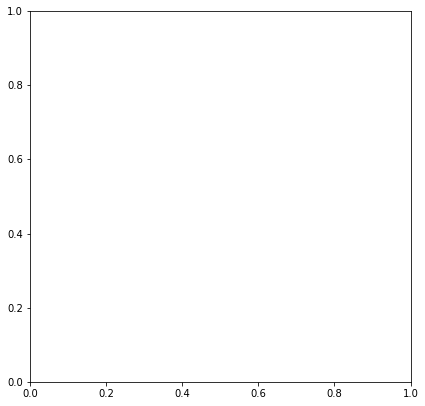

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(50)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()